In [1]:
# Import Libraries
import pandas_datareader as web
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

### Initialize DataFrame

In [2]:
def historical_adjcloses(tickers, days) :
    start = dt.datetime.today() - dt.timedelta(days)
    
    try :
        stock_prices = [web.DataReader(ticker, 'yahoo', start, dt.datetime.today()) for ticker in tickers]
    except :
        return pd.DataFrame()

    adj_closes = {}
    for i in range(len(tickers)) :
        adj_closes[tickers[i]] = stock_prices[i]['Adj Close'].apply(lambda x : round(x, 2))

    adj_closes = pd.DataFrame.from_dict(adj_closes)
    dates = [day.date() for day in adj_closes.index]
    adj_closes = adj_closes.reindex(dates)

    return adj_closes

In [3]:
tickers = ['TSLA', 'MSFT', 'AAPL', 'FB', 'NVDA', 'AMD', 'QCOM', 'CLVS']
adj_closes = historical_adjcloses(tickers = tickers, days = 365)

In [4]:
display(adj_closes.head())

,TSLA,MSFT,AAPL,FB,NVDA,AMD,QCOM,CLVS
Date,,,,,,,,
2021-08-30,243.64,301.07,152.27,380.66,226.73,111.32,143.36,4.83
2021-08-31,245.24,299.37,150.98,379.38,223.74,110.72,144.10,4.82
2021-09-01,244.70,299.32,151.66,382.05,224.30,109.99,144.53,4.92
2021-09-02,244.13,298.65,152.79,375.28,223.85,109.20,143.22,4.90
2021-09-03,244.52,298.64,153.44,376.26,228.31,109.92,142.74,4.62


In [5]:
display(adj_closes.tail())

,TSLA,MSFT,AAPL,FB,NVDA,AMD,QCOM,CLVS
Date,,,,,,,,
2022-08-23,296.45,276.44,167.23,161.11,171.81,92.49,140.72,1.27
2022-08-24,297.10,275.79,167.53,163.26,172.22,92.73,141.31,1.25
2022-08-25,296.07,278.85,170.03,168.78,179.13,97.18,146.25,1.27
2022-08-26,288.09,268.09,163.62,161.78,162.60,91.18,138.38,1.19
2022-08-29,284.82,265.23,161.38,159.17,158.01,88.49,137.08,1.19


### Plot Adjusted Closes

In [6]:
def plot_adjcloses(tickers_df) :
    plt.figure(figsize = (20, 12))
    plt.yscale('log')

    for ticker in tickers_df.columns : 
        lineplot = plt.plot(
            tickers_df[ticker], 
            linewidth = 2.5,
            label = ticker
        )

    plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0, fontsize = 12.5).set_title('Tickers', prop = {'size' : 17.5})
    
    plt.xlabel('Date', fontsize = 17.5)
    plt.ylabel('Adjusted Close ($log_{10}$)', fontsize = 17.5)
    plt.title('Market Prices', fontsize = 25)
    plt.show()

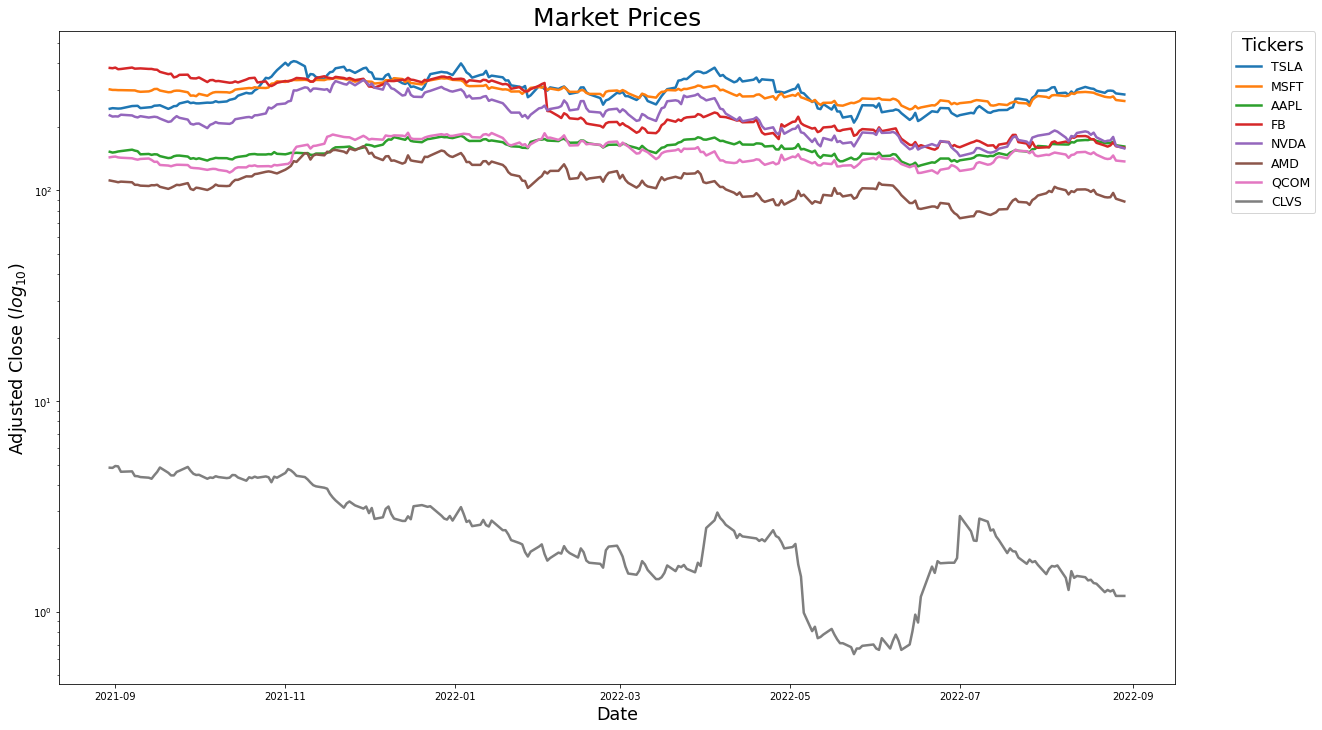

In [7]:
plot_adjcloses(adj_closes)

### Technical Stock Analysis - Relative Strength Index (RSI)  

In [8]:
def plot_rsi(ticker, stock_df) :
    plt.figure(figsize = (12, 8))

    # First Subplot is Adj Closes.
    ax1 = plt.subplot(211)
    ax1.plot(
        stock_df.index, stock_df['Adj Closes'], 
        linewidth = 2.5, color = 'lightgray'
    )

    ax1.grid(True, color = '#555555')
    ax1.tick_params(axis = 'x', colors = 'white')
    ax1.tick_params(axis = 'y', colors = 'white')
    ax1.set_axisbelow(True)
    
    ax1.set_facecolor('black')
    ax1.set_title(str(ticker) + ': Adjusted Close Price', color = 'white', fontweight = 'bold')

    # Second Subplot is RSI.
    ax2 = plt.subplot(212, sharex = ax1)
    ax2.plot(
        stock_df.index, stock_df['RSI'], 
        linewidth = 2.5, color = 'lightgray'
    )

    # RSI Line Markings.
    for i in range(0, 110, 10) :
        if (i == 0 or i == 100) : # Red If RSI = 0, RSI = 100.
            ax2.axhline(i, linestyle = '--', alpha = 0.5, color = '#ff0000')
        elif (i == 10 or i == 90) : # Yellow If RSI = 10, RSI = 90.
            ax2.axhline(i, linestyle = '--', alpha = 0.5, color = '#ffaa00')
        elif (i == 20 or i == 80) : # Green If RSI = 20, RSI = 80.
            ax2.axhline(i, linestyle = '--', alpha = 0.5, color = '#00ff00')
        elif (i == 30 or i == 70) : # Lightgray If RSI = 30 (i.e. Oversold), RSI = 70 (i.e. Overbought).
            ax2.axhline(i, linestyle = '--', alpha = 1, color = '#cccccc');

    ax2.grid(False)
    ax2.tick_params(axis = 'x', colors = 'white')
    ax2.tick_params(axis = 'y', colors = 'white')
    ax2.set_yticks([i for i in range(0, 110, 10) if i <= 30 or i >= 70])
    ax2.set_axisbelow(True)
    
    ax2.set_facecolor('black')
    ax2.set_title('RSI Value', color = 'white', fontweight = 'bold')

    plt.show()

In [9]:
def get_rsi(ticker, adj_closes, days) :
    delta = adj_closes.diff(1)
    delta.dropna(inplace = True)
    
    positive = delta.copy()
    positive[positive < 0] = 0 # Keep positive deltas.

    negative = delta.copy()
    negative[negative > 0] = 0 # Keep negative deltas.
    
    average_gain = positive.rolling(window = days).mean()
    average_loss = abs(negative.rolling(window = days).mean())
    rsi = (100.0 - (100.0 / (1.0 + average_gain / average_loss))).rename('RSI').to_frame()

    stock_df = pd.merge(adj_closes, rsi, left_index = True, right_index = True)
    stock_df.rename(columns = {ticker : 'Adj Closes'}, inplace = True)

    plot_rsi(ticker, stock_df)

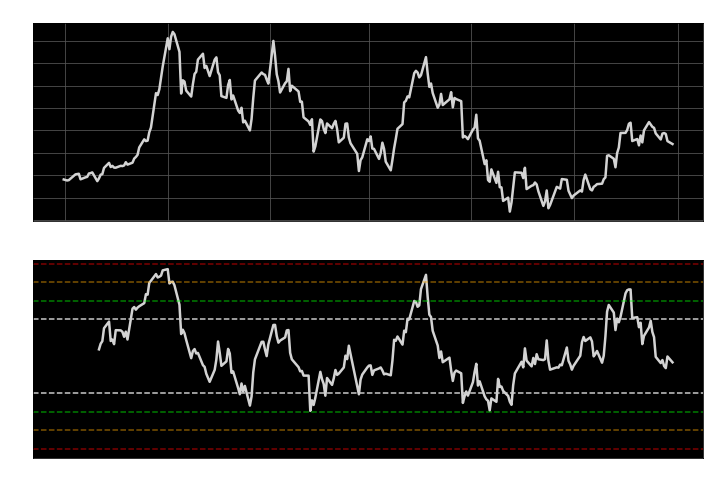

In [10]:
get_rsi(
    ticker = 'TSLA',
    adj_closes = adj_closes['TSLA'], 
    days = 15 
)

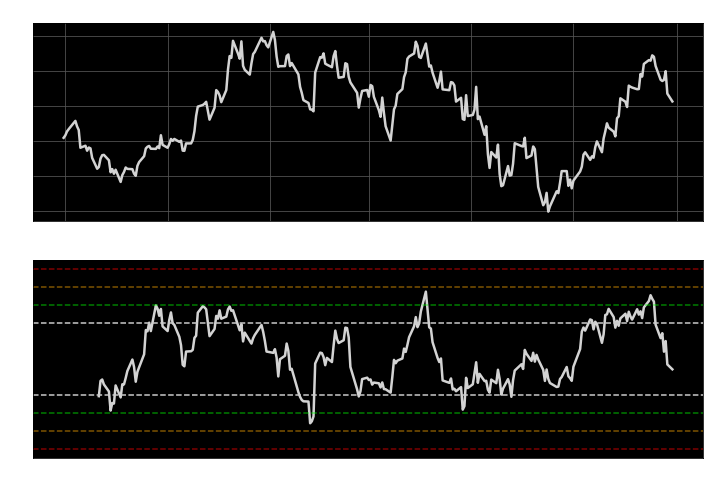

In [11]:
get_rsi(
    ticker = 'AAPL',
    adj_closes = adj_closes['AAPL'], 
    days = 15 
)

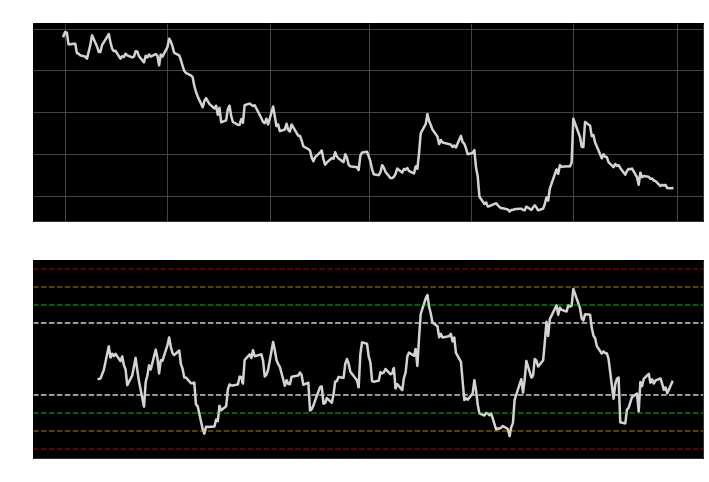

In [12]:
get_rsi(
    ticker = 'CLVS',
    adj_closes = adj_closes['CLVS'], 
    days = 15 
)

### Correlation Heatmap (Pearson's Correlation Matrix)

In [13]:
corr_data = adj_closes.pct_change().corr(method = 'pearson').apply(lambda x : round(x * 100, 2))
display(corr_data.head())

,TSLA,MSFT,AAPL,FB,NVDA,AMD,QCOM,CLVS
TSLA,100.00,58.05,64.03,42.81,63.79,62.67,50.79,30.11
MSFT,58.05,100.00,78.63,60.49,75.03,67.23,61.67,29.12
AAPL,64.03,78.63,100.00,58.20,73.10,66.66,65.75,27.64
FB,42.81,60.49,58.20,100.00,62.16,57.12,59.45,18.28
NVDA,63.79,75.03,73.10,62.16,100.00,86.07,78.23,25.51


In [14]:
def display_heatmap(corr_data) :
    plt.figure(figsize = (20, 12))

    heatmap = sns.heatmap(
        data = corr_data,
        annot = corr_data.values, annot_kws = {'fontsize' : 12.5},
        cmap = 'YlGnBu',
        cbar = True, 
        linewidth = 2, linecolor = 'black', 
        square = True
    )

    heatmap.set_xlabel('Stocks', fontsize = 18)
    heatmap.set_ylabel('Stocks', fontsize = 18)

    heatmap.figure.axes[-1].set_ylabel('Percentage (%)', size = 18)

    heatmap.set_title('Stock Correlations', fontsize = 25)
    plt.show()

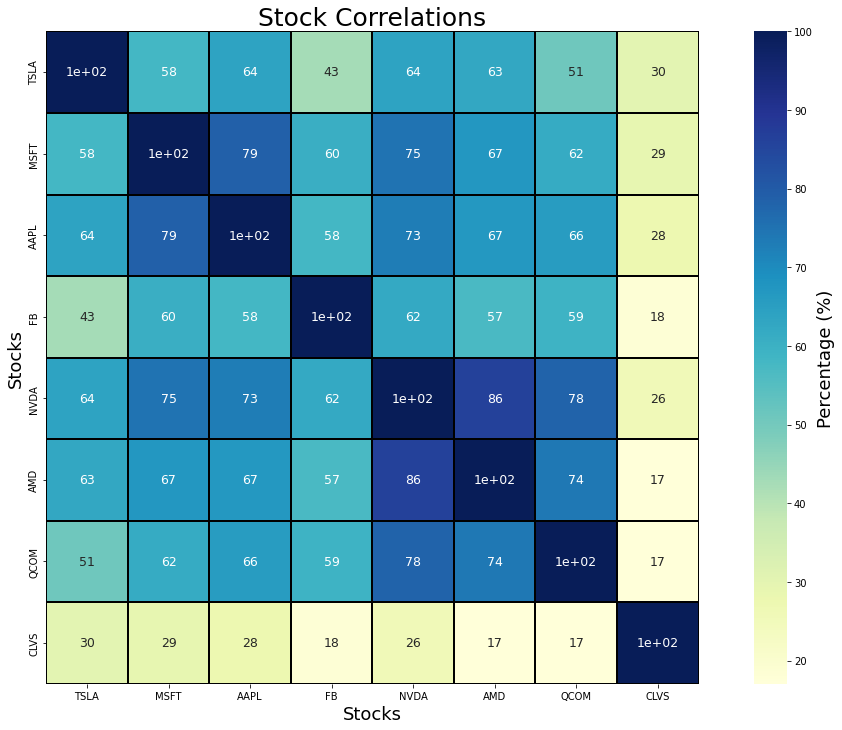

In [15]:
display_heatmap(corr_data)

# Stock Portfolio

In [16]:
def create_portfolio(start) :
    effective_dates = []
    for number_days in range(int((dt.datetime.today().date() - start).days)) :
        effective_dates.append(start + dt.timedelta(number_days))

    portfolio = pd.DataFrame(columns = tickers, index = effective_dates).fillna(0)
    portfolio.index.name = 'Date'

    balances = {}
    for ticker in portfolio.columns :
        balances[ticker] = 0
    return portfolio, balances

In [17]:
def purchase_stock(portfolio, starting_balances, ticker, shares, date) :
    for current, row in portfolio.iterrows() :
        difference = (current - date).days
        
        if difference >= 0 :
            row[ticker] += shares
    
    starting_balances[ticker] += shares * float(adj_closes[ticker][adj_closes.index == date])

In [18]:
def calculate_balance(portfolio, date) :
    current = 0
    for ticker in portfolio.columns :
        current += float(portfolio[ticker][portfolio.index == date]) * float(adj_closes[ticker][adj_closes.index == date])
    return round(current, 2)

In [19]:
def calculate_balances(portfolio, date) :
    current_balances = {}
    for ticker in portfolio.columns :
        current_balance = calculate_balance(
            portfolio = portfolio[ticker].to_frame(), 
            date = date
        ) 
        if current_balance > 0 : 
            current_balances[ticker] = current_balance
    return current_balances

In [20]:
def calculate_profit(portfolio, starting_balance, date) :    
    return round((calculate_balance(portfolio, date) - starting_balance), 2)

In [21]:
def calculate_profits(portfolio, loaded_balances, date) :
    profits = {}
    current_balances = calculate_balances(portfolio, date)
    for ticker in current_balances.keys() :
        profits[ticker] = calculate_profit(
            portfolio = portfolio[ticker].to_frame(),
            starting_balance = loaded_balances[ticker],
            date = date
        ) 
    return profits

In [22]:
portfolio, loaded_balances = create_portfolio(start = dt.date(2022,1,1)) 
print(loaded_balances)

{'TSLA': 0, 'MSFT': 0, 'AAPL': 0, 'FB': 0, 'NVDA': 0, 'AMD': 0, 'QCOM': 0, 'CLVS': 0}


In [23]:
purchase_stock(
    portfolio = portfolio, 
    starting_balances = loaded_balances,
    ticker = 'AAPL', 
    shares = 14, 
    date = dt.date(2022, 2, 18) 
)

purchase_stock(
    portfolio = portfolio, 
    starting_balances = loaded_balances,
    ticker = 'CLVS', 
    shares = 1352, 
    date = dt.date(2022, 2, 18) 
)

In [24]:
purchase_stock(
    portfolio = portfolio, 
    starting_balances = loaded_balances,
    ticker = 'AAPL', 
    shares = 4, 
    date = dt.date(2022, 2, 24) 
)

In [25]:
purchase_stock(
    portfolio = portfolio, 
    starting_balances = loaded_balances,
    ticker = 'CLVS', 
    shares = 415, 
    date = dt.date(2022, 2, 25) 
)

In [26]:
purchase_stock(
    portfolio = portfolio, 
    starting_balances = loaded_balances,
    ticker = 'AAPL', 
    shares = 5, 
    date = dt.date(2022, 3, 14) 
)

In [27]:
display(portfolio.tail())

,TSLA,MSFT,AAPL,FB,NVDA,AMD,QCOM,CLVS
Date,,,,,,,,
2022-08-24,0,0,23,0,0,0,0,1767
2022-08-25,0,0,23,0,0,0,0,1767
2022-08-26,0,0,23,0,0,0,0,1767
2022-08-27,0,0,23,0,0,0,0,1767
2022-08-28,0,0,23,0,0,0,0,1767


In [28]:
sum(loaded_balances.values())

6894.07

In [29]:
profit = calculate_profit(
    portfolio = portfolio['AAPL'].to_frame(), 
    starting_balance = loaded_balances['AAPL'], 
    date = dt.date(2022, 4, 6)
)
print(profit)

205.27


In [30]:
current_balances = calculate_balances(
    portfolio = portfolio, 
    date = dt.date(2022, 4, 6)
)
current_balances

{'AAPL': 3940.82, 'CLVS': 4929.93}

In [31]:
profits = calculate_profits(
    portfolio = portfolio, 
    loaded_balances = loaded_balances, 
    date = dt.date(2022, 4, 6)
)
profits

{'AAPL': 205.27, 'CLVS': 1771.41}

### Visualize Stock Porfolio

In [32]:
def display_portfolio(current_balances, profits) :
    fig, ax = plt.subplots(figsize = (16, 8))
    ax.set_facecolor('black')
    ax.set_title('Stock Portfolio', color = 'white', fontweight = 'bold', size = 20)

    ax.tick_params(axis = 'x', color = 'white')
    ax.tick_params(axis = 'y', color = 'white')

    wedges, texts, autotexts = ax.pie(
        current_balances.values(),    
        labels = current_balances.keys(),
        textprops = dict(color = 'black'),    
        autopct = '%1.1f%%',
        pctdistance = 0.8
    )

    [text.set_color('white') for text in texts]

    plt.setp(texts, size = 10, weight = 'bold')
    plt.setp(autotexts, size = 10, weight = 'bold')

    chart_center = plt.Circle((0, 0), 0.45, color = 'black')
    plt.gca().add_artist(chart_center)

    # Portfolio Preview Label 

    ax.text(
        x = -2, y = 1, 
        s = 'Portfolio Preview', 
        fontsize = 14, 
        fontweight = 'bold',
        color = 'white', 
        verticalalignment = 'center',
        horizontalalignment = 'center'
    )
    
    # Current Balances

    ax.text(
        x = -2, y = 0.85, 
        s = f'Total : {sum(current_balances.values()):.2f} USD', 
        fontsize = 12,
        fontweight = 'semibold', 
        color = 'white', 
        verticalalignment = 'center',
        horizontalalignment = 'center'
    )
    
    # Profits

    offset = -0.15
    for ticker, profit in profits.items() :
        if profit > 0 :
            profit_display = f'{ticker} : +{profit:.2f} USD'
            text_color = 'green'
        if profit < 0 :
            profit_display = f'{ticker} : {profit:.2f} USD'
            text_color = 'red'
        if profit == 0 :
            profit_display = f'{ticker} : {profit:.2f} USD'
            text_color = 'white'
        ax.text(
            x = -2, y = 0.85 + offset, 
            s = profit_display, 
            fontsize = 12, 
            fontweight = 'semibold',
            color = text_color, 
            verticalalignment = 'center',
            horizontalalignment = 'center'
        )
        offset -= 0.15

    plt.show()

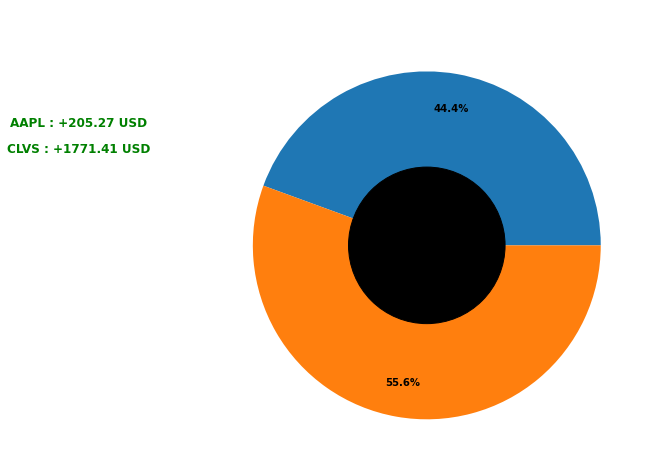

In [33]:
display_portfolio(current_balances, profits)